In [1]:
import torch
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
from pytorch_resnet_cifar10 import resnet
import model_utils
import pruning

/home/zache1/anaconda3/envs/pyt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the CIFAR-10 Datasets (Train and Test)

In [2]:
# perform the same transform on all the data
transform = tv.transforms.Compose(
    [tv.transforms.ToTensor(), # scale the data between 0..1
     tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize the data

# get the cifar10 data
data_train = tv.datasets.CIFAR10(root="data/CIFAR10/train", train=True, download=True, transform=transform)
data_test = tv.datasets.CIFAR10(root="data/CIFAR10/test", train=False, download=True, transform=transform)

# create the dataloaders for each dataset. These will be used for training and getting accuracy of a model
dataloader_train = torch.utils.data.DataLoader(data_train, batch_size=128, shuffle=False)
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size=128, shuffle=False)

print(np.shape(data_test.data))

Files already downloaded and verified
Files already downloaded and verified
(10000, 32, 32, 3)


Get the device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Function for loading the pre-trained model

In [4]:
def loadOriginalModel(device):
    model = resnet.resnet56()

    # load the model with the correct weights
    # must use DataParallel since the data was saved as a DataParallel
    torch.nn.DataParallel(model).load_state_dict(torch.load('pytorch_resnet_cifar10/pretrained_models/resnet56-4bfd9763.th', map_location=device)['state_dict'])

    model.to(device)

    model_utils.prepare_model(model)

    return model

In [5]:
model = loadOriginalModel(device)
initial_accuracy = model_utils.get_accuracy(model, dataloader_test, device)

Function for training a model

In [6]:
def train(model, epochs, dataloader):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.0001)

    for i in range(epochs):
        for (images, labels) in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
        print("\t\tEpoch: {}".format(i))

Set the target pruned percentages<br>
Set the target number of epochs<br>
Set how many times the program will run<br>

In [7]:
pruned_percentages = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
total_epochs = 120
iteration_times = 10

For simplicity sake, the total number of epochs should be a multiple of the amount of times pruning

In [8]:
assert total_epochs % np.size(pruned_percentages) == 0 

Gradual pruning:

In [9]:
percent_per_prune = np.append(pruned_percentages[0], 1 - ((1 - pruned_percentages[1:]) / (1 - pruned_percentages[0:-1])))

gradual_accuracies = []
gradual_actual_pruned_percentages = []

for _ in range(iteration_times):
    model = loadOriginalModel(device)
    times_pruned = np.size(percent_per_prune)
    epochs = total_epochs // times_pruned
    accuracy = np.zeros(times_pruned)
    actual_pruned_percentage = np.zeros(times_pruned)
    for indx, percent in enumerate(percent_per_prune):
        pruning.global_mag_weight_prune(model, percent)
        train(model, epochs, dataloader_train)
        accuracy[indx] = model_utils.get_accuracy(model, dataloader_test, device)
        actual_pruned_percentage[indx] = model_utils.pruned_percentage(model, 'weight')
    gradual_accuracies.append(accuracy)
    gradual_actual_pruned_percentages.append(actual_pruned_percentage)

		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch

Instant Pruning

In [13]:
instant_accuracies = []
instant_actual_pruned_percentages = []

for _ in range(iteration_times):
    times_pruned = np.size(pruned_percentages)
    epochs = total_epochs // times_pruned
    epochs_increase = total_epochs // times_pruned
    accuracy = np.zeros(times_pruned)
    actual_pruned_percentage = np.zeros(times_pruned)
    for indx, percent in enumerate(pruned_percentages):
        model = loadOriginalModel(device)
        pruning.global_mag_weight_prune(model, percent)
        train(model, epochs, dataloader_train)
        epochs += epochs_increase # increase the total number of epochs to match the gradual pruning
        accuracy[indx] = model_utils.get_accuracy(model, dataloader_test, device)
        actual_pruned_percentage[indx] = model_utils.pruned_percentage(model, 'weight')
    instant_accuracies.append(accuracy)
    instant_actual_pruned_percentages.append(actual_pruned_percentage)

		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12
		Epoch: 13
		Epoch: 14
		Epoch: 15
		Epoch: 16
		Epoch: 17
		Epoch: 18
		Epoch: 19
		Epoch: 20
		Epoch: 21
		Epoch: 22
		Epoch: 23
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12
		Epoch: 13
		Epoch: 14
		Epoch: 15
		Epoch: 16
		Epoch: 17
		Epoch: 18
		Epoch: 19
		Epoch: 20
		Epoch: 21
		Epoch: 22
		Epoch: 23
		Epoch: 24
		Epoch: 25
		Epoch: 26
		Epoch: 27
		Epoch: 28
		Epoch: 29
		Epoch: 30
		Epoch: 31
		Epoch: 32
		Epoch: 33
		Epoch: 34
		Epoch: 35
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12
		Epoch: 13
		Epoch:

In [14]:
print(gradual_accuracies)
print(instant_accuracies)

[array([0.8986, 0.8921, 0.8859, 0.8903, 0.8938, 0.8814, 0.8916, 0.8832,
       0.8526, 0.8542]), array([0.898 , 0.8953, 0.8949, 0.8892, 0.89  , 0.8826, 0.8846, 0.889 ,
       0.8869, 0.863 ]), array([0.8983, 0.8949, 0.8946, 0.8865, 0.8938, 0.8918, 0.8892, 0.8908,
       0.8608, 0.8579]), array([0.8932, 0.8984, 0.8905, 0.89  , 0.8931, 0.8924, 0.8764, 0.8907,
       0.855 , 0.8574]), array([0.8957, 0.895 , 0.8933, 0.8908, 0.8908, 0.8912, 0.8866, 0.8889,
       0.8683, 0.8612]), array([0.8939, 0.8934, 0.8938, 0.8873, 0.8905, 0.8838, 0.8913, 0.8925,
       0.8627, 0.8632]), array([0.8991, 0.8899, 0.8838, 0.8935, 0.8886, 0.8854, 0.8855, 0.8892,
       0.8786, 0.859 ]), array([0.8926, 0.8923, 0.8868, 0.8887, 0.8867, 0.8914, 0.8867, 0.8927,
       0.8739, 0.8639]), array([0.8984, 0.8971, 0.8961, 0.8841, 0.8893, 0.8878, 0.8896, 0.886 ,
       0.8648, 0.8633]), array([0.8955, 0.8928, 0.8893, 0.8893, 0.8896, 0.883 , 0.8889, 0.8929,
       0.8764, 0.8649])]
[array([0.8972, 0.8931, 0.8938, 0.8973,

In [15]:
print(gradual_actual_pruned_percentages)
print(instant_actual_pruned_percentages)

[array([0.10000047, 0.20000094, 0.30000141, 0.40000188, 0.50000235,
       0.60000282, 0.70000212, 0.80000141, 0.90000071, 0.95000094]), array([0.10000047, 0.20000094, 0.30000141, 0.40000188, 0.50000235,
       0.60000282, 0.70000212, 0.80000141, 0.90000071, 0.95000094]), array([0.10000047, 0.20000094, 0.30000141, 0.40000188, 0.50000235,
       0.60000282, 0.70000212, 0.80000141, 0.90000071, 0.95000094]), array([0.10000047, 0.20000094, 0.30000141, 0.40000188, 0.50000235,
       0.60000282, 0.70000212, 0.80000141, 0.90000071, 0.95000094]), array([0.10000047, 0.20000094, 0.30000141, 0.40000188, 0.50000235,
       0.60000282, 0.70000212, 0.80000141, 0.90000071, 0.95000212]), array([0.10000047, 0.20000094, 0.30000141, 0.40000188, 0.50000235,
       0.60000282, 0.70000212, 0.80000141, 0.90000071, 0.95000094]), array([0.10000047, 0.20000094, 0.30000141, 0.40000188, 0.50000235,
       0.60000282, 0.70000212, 0.80000141, 0.90000071, 0.95000094]), array([0.10000047, 0.20000094, 0.30000141, 0.40

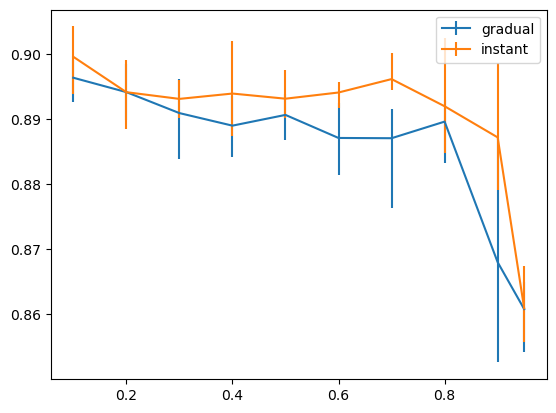

In [22]:
fig, ax = plt.subplots()
gradual_avg = np.mean(gradual_accuracies, axis=0)
gradual_max = np.max(gradual_accuracies, axis=0)
gradual_min = np.min(gradual_accuracies, axis=0)
ax.errorbar(gradual_actual_pruned_percentages[0], gradual_avg, yerr=(gradual_avg - gradual_min, gradual_max - gradual_avg), label="gradual")
instant_avg = np.mean(instant_accuracies, axis=0)
instant_max = np.max(instant_accuracies, axis=0)
instant_min = np.min(instant_accuracies, axis=0)
ax.errorbar(instant_actual_pruned_percentages[0], instant_avg, yerr=(instant_avg - instant_min, instant_max - instant_avg), label="instant")
ax.legend()